<a href="https://colab.research.google.com/github/hilalongel/DSA-210-project/blob/main/3ModelsofMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving final_exploded_boxoffice_with_genres_and_seasons.csv to final_exploded_boxoffice_with_genres_and_seasons (4).csv
Model Comparison:
                Model    MAE    RMSE      R2
0      Random Forest  60.29   89.09  0.7107
1  Linear Regression  76.73  115.59  0.5130
2      Decision Tree  66.37  114.07  0.5257

Selected Model: Random Forest (Highest R² = 0.7107)


<ipython-input-5-3a4f86530ad8>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="R2", palette="viridis")


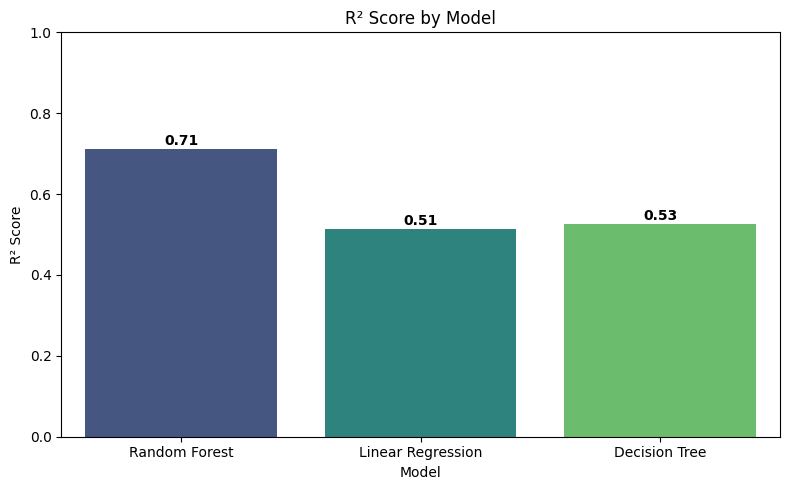

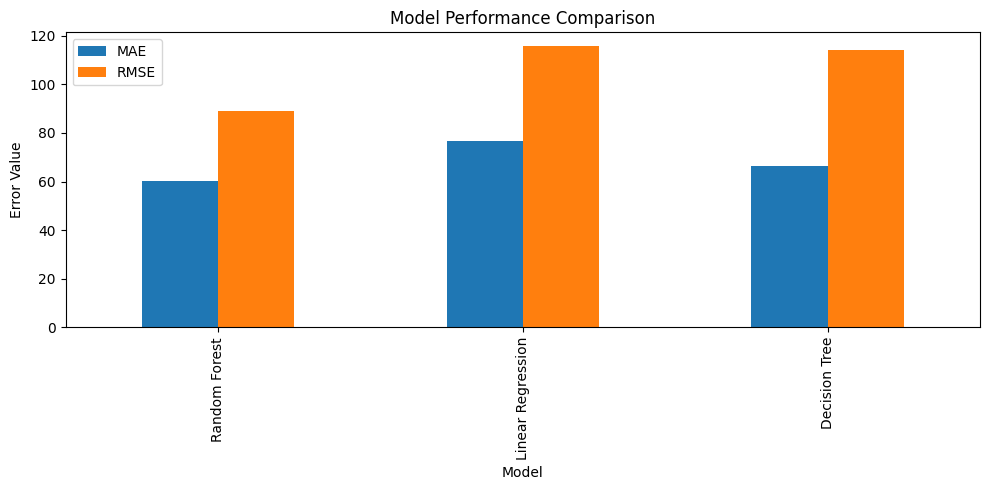

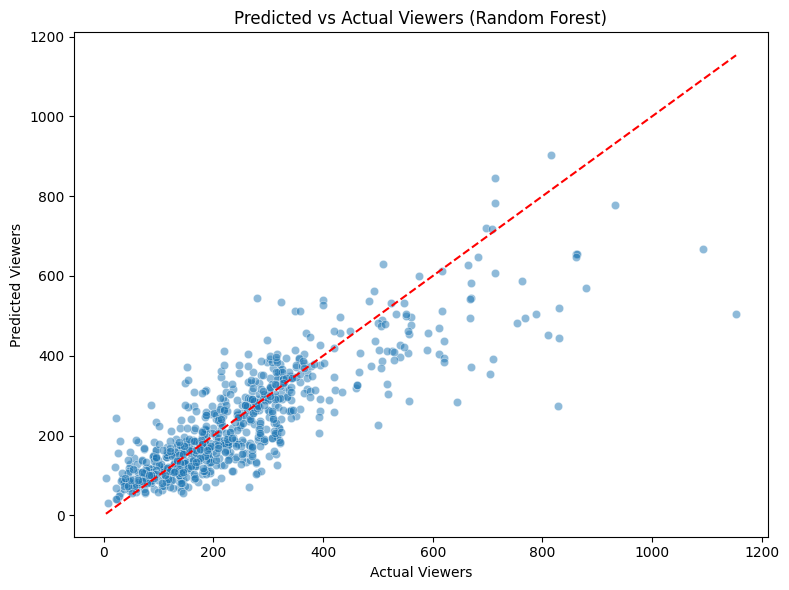

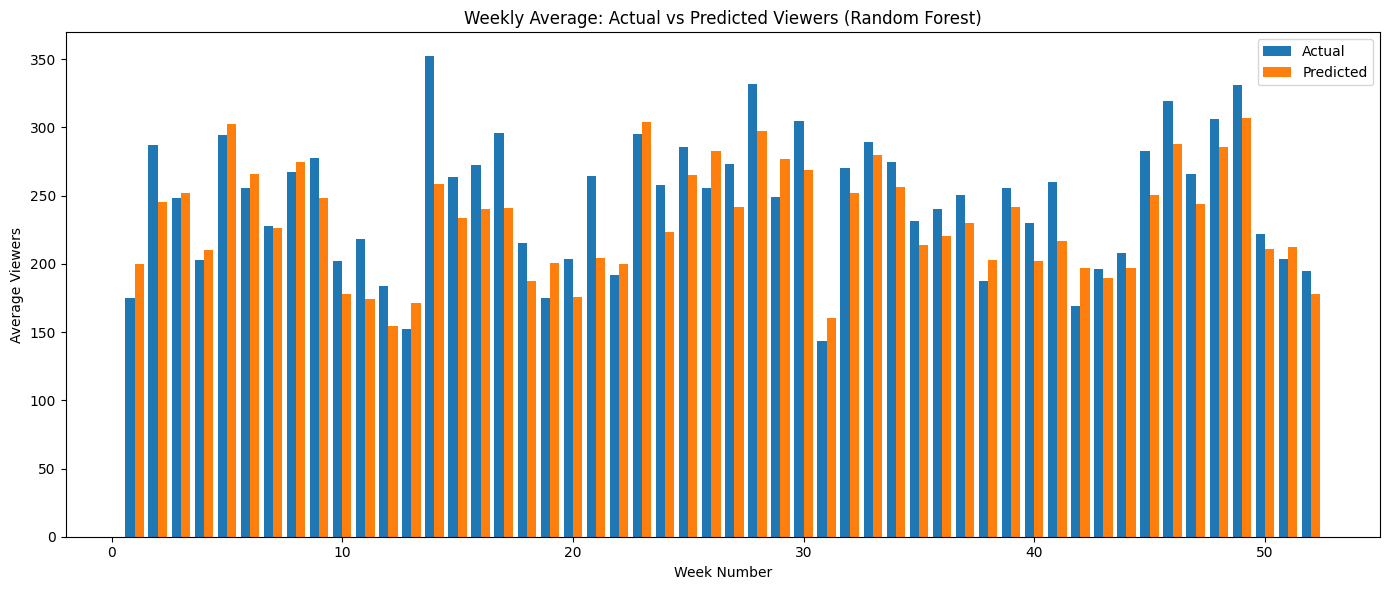

In [5]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Upload CSV
from google.colab import files
uploaded = files.upload()

# Read uploaded file
df = pd.read_csv("final_exploded_boxoffice_with_genres_and_seasons.csv")

# Feature Engineering
df['Movie_Rank'] = df.groupby(['Year', 'Week']).cumcount() + 1
holiday_weeks = list(range(1, 3)) + list(range(26, 32)) + [52]
df['IsHolidayWeek'] = df['Week'].apply(lambda x: 1 if x in holiday_weeks else 0)
df['GenreCount'] = 1
df['Log_Viewers'] = np.log1p(df['Viewers'])

# One-hot encoding for Season and Genre
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical = df[['Season', 'Genres_List']]
encoded = encoder.fit_transform(categorical)
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Season', 'Genres_List']))

# Combine all features
numerical = df[['Week', 'Year', 'Movie_Rank', 'IsHolidayWeek', 'GenreCount']].reset_index(drop=True)
X = pd.concat([numerical, encoded_df], axis=1)
y_log = df['Log_Viewers'].reset_index(drop=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
y_test_actual = np.expm1(y_test)

# Train and compare models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    mae = mean_absolute_error(y_test_actual, y_pred)
    rmse = mean_squared_error(y_test_actual, y_pred) ** 0.5
    r2 = r2_score(y_test_actual, y_pred)

    results.append({
        "Model": name,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "R2": round(r2, 4)
    })

results_df = pd.DataFrame(results)
print("Model Comparison:\n", results_df)

# Highlight best model based on R²
best_model_row = results_df.loc[results_df["R2"].idxmax()]
best_model_name = best_model_row["Model"]
best_model_r2 = best_model_row["R2"]
print(f"\nSelected Model: {best_model_name} (Highest R² = {best_model_r2})")

# R² comparison bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="Model", y="R2", palette="viridis")
plt.title("R² Score by Model")
plt.ylabel("R² Score")
plt.ylim(0, 1)
for i, val in enumerate(results_df["R2"]):
    plt.text(i, val + 0.01, f"{val:.2f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig("r2_score_comparison.png", dpi=300)
plt.show()
print("")

# Visualize error comparison
results_df.set_index("Model")[["MAE", "RMSE"]].plot(kind="bar", figsize=(10,5))
plt.title("Model Performance Comparison")
plt.ylabel("Error Value")
plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300)
plt.show()
print("")

# Best model prediction (use model selected by R²)
best_model = models[best_model_name]
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Prediction vs Actual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_actual, y=y_pred, alpha=0.5)
plt.xlabel("Actual Viewers")
plt.ylabel("Predicted Viewers")
plt.title(f"Predicted vs Actual Viewers ({best_model_name})")
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], '--r')
plt.tight_layout()
plt.savefig("prediction_vs_actual.png", dpi=300)
plt.show()
print("")

# Weekly averages
X_test_with_index = X_test.copy()
X_test_with_index["Week"] = df.loc[X_test.index, "Week"].values
weekly_df = pd.DataFrame({
    "Week": X_test_with_index["Week"],
    "Actual": y_test_actual,
    "Predicted": y_pred
})
weekly_avg = weekly_df.groupby("Week").mean(numeric_only=True).reset_index()

plt.figure(figsize=(14, 6))
bar_width = 0.4
plt.bar(weekly_avg["Week"] - bar_width/2, weekly_avg["Actual"], width=bar_width, label="Actual")
plt.bar(weekly_avg["Week"] + bar_width/2, weekly_avg["Predicted"], width=bar_width, label="Predicted")
plt.xlabel("Week Number")
plt.ylabel("Average Viewers")
plt.title(f"Weekly Average: Actual vs Predicted Viewers ({best_model_name})")
plt.legend()
plt.tight_layout()
plt.savefig("bar_weekly_avg_actual_vs_predicted.png", dpi=300)
plt.show()
